<a href="https://colab.research.google.com/github/nykolai-d/nlp_tag_prediction/blob/main/Stack_Overflow_Tag_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tag prediction on Stack Overflow

This notebook trains a multi-class classifier to predict the tag of a programming question on Stack Overflow. It was built based on a model by François Chollet (see license bellow).



In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [2]:
print(tf.__version__)


2.6.0


In [3]:
#Downloading and extracting the dataset

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'train')


In [4]:
#Listing the directories

os.listdir(dataset_dir)


['csharp', 'python', 'java', 'javascript']

In [5]:
train_dir = os.path.join(dataset_dir)
os.listdir(train_dir)


['csharp', 'python', 'java', 'javascript']

In [6]:
#This is a sample file from the dataset

sample_file = os.path.join(train_dir, 'python/10.txt')
with open(sample_file) as f:
  print(f.read())


"how to read instance variables from another file without instantiating the class? i'm relatively new to blank and i'm having some trouble importing a variable to use it in another class. i did look at several other questions on this topic and tried to make it work, but it seems the way i set up this program early on might be the problem. i'll simplify what's going on so there's less to read.....server.py:..import game.class server():.    def __init__(self):.        # server connection details here.        self.test = 5.        self.game = game()..    def serve(self):.        # client processing, etc..        self.game.game_loop()..if __name__ == ""__main__"":.    server = server().    server.serve()...game.py:..class game():.    def __init__(self):.        # other variables.....    def game_loop(self):.        # to reference server's instance variables.        from server import server..        print test...in this example, i'm trying to reference the variable ""test"" from the server

In [7]:
#Using the text_dataset_from_directory utility to create a labeled tf.data.Dataset

batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size)


Found 8000 files belonging to 4 classes.


In [9]:
#Iterating over the dataset and printing out a few examples

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Review: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])


Review:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [10]:
#Checking what the labels stand for

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])


Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [11]:
#Creating a validation and test dataset

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [12]:
#Standardizing, tokenizing and vectorizing the data using the preprocessing.TextVectorization layer.

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [14]:
# Making a text-only dataset (without labels), then calling adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [15]:
#Creating a function to see the result of using this layer to preprocess some data.

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [16]:
# Retrieving a batch of 32 reviews and labels from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [18]:
#Each token has been replaced by an integer. Printing some examples:

print("1078 ---> ",vectorize_layer.get_vocabulary()[1078])
print(" 218 ---> ",vectorize_layer.get_vocabulary()[218])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
#

1078 --->  happen
 218 --->  last
Vocabulary size: 10000


In [23]:
#Applying the TextVectorization layer we created earlier to the train, validation and test dataset.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [19]:
#Creating the neural network

embedding_dim = 16


In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# The layers are stacked sequentially to build the classifier:

# 1. The first layer is an Embedding layer. This layer takes the integer-encoded reviews and 
# looks up an embedding vector for each word-index. These vectors are learned as the model trains. 
# The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). 
# 2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by 
# averaging over the sequence dimension. This allows the model to handle input of variable length, 
# in the simplest way possible.
# 3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
 #4. The last layer is densely connected with a single output node.

In [21]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# Loss function and optimizer
# A model needs a loss function and an optimizer for training. 
# Since this is a multi-class classification problem and the model outputs a probability, 
# we use tf.keras.losses.SparseCategoricalCrossentropy loss function.


In [24]:
#Training the model

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
200/200 [==============================] - 4s 16ms/step - loss: 1.3793 - accuracy: 0.3366 - val_loss: 1.3684 - val_accuracy: 0.5019
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 1.3514 - accuracy: 0.4634 - val_loss: 1.3308 - val_accuracy: 0.5612
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3016 - accuracy: 0.5420 - val_loss: 1.2731 - val_accuracy: 0.6062
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 1.2345 - accuracy: 0.6012 - val_loss: 1.2005 - val_accuracy: 0.6356
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 1.1564 - accuracy: 0.6442 - val_loss: 1.1254 - val_accuracy: 0.6787
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0796 - accuracy: 0.6825 - val_loss: 1.0540 - val_accuracy: 0.7119
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0085 - accuracy: 0.7122 - val_loss: 0.9877 - val_accuracy: 0.7337

In [25]:
#Evaluating the model

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


250/250 [==============================] - 3s 10ms/step - loss: 0.8005 - accuracy: 0.7891
Loss:  0.8005365133285522
Accuracy:  0.7891250252723694


In [26]:
#Creating a plot of accuracy and loss over time

history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

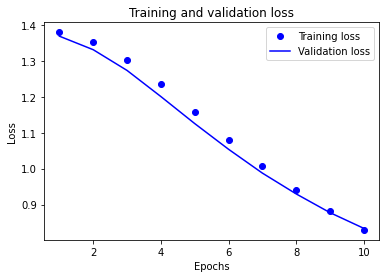

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


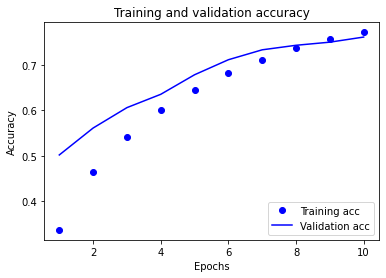

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [29]:
#Exporting the model

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


250/250 [==============================] - 3s 10ms/step - loss: 0.8005 - accuracy: 0.7891
0.7891250252723694


In [ ]:
#Getting inference on new data by calling model.predict()

examples = [
  "The variables are to be declared",
  "I would like to make a list of arrays",
  "Do I need to print do debug"
]

export_model.predict(examples)


array([[0.5330841 , 0.46359873, 0.5488741 , 0.43400502],
       [0.5062539 , 0.45500866, 0.53705674, 0.4869223 ],
       [0.5204844 , 0.45168835, 0.5374115 , 0.47488147]], dtype=float32)

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
